### Project Name: House Prices: Advanced Regression Techniques
The main aim of this project is to predict the house price based on various features which we will discuss as we go ahead

#### Dataset to downloaded from the below link
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

### Approach
1. Exploratory Data Analysis
2. Feature Engineering
3. Feature Selection
4. Model Building
5. Hyperparameter Tuning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

import seaborn as sns

pd.pandas.set_option('display.max_columns', None)
# pd.pandas.set_option('display.max_rows', None)

In [2]:
trainData = pd.read_csv('./trainData_prepared.csv')
testData = pd.read_csv('./testData_prepared.csv')
testFinal = pd.read_csv('./testData_featureSelection.csv')

In [3]:
train_df_copy = trainData.copy()
test_df_copy = testFinal.copy()
house_price = testData["SalePrice"]

In [4]:
print(trainData.shape, testData.shape,testFinal.shape)

(1460, 76) (1460, 1) (1459, 76)


## 4. Model Building

In [5]:
df = pd.concat([trainData, testFinal], axis=0)
df.shape

(2919, 76)

In [6]:
categorical_attributes = df.select_dtypes(include= ['object']).columns.tolist()
print('Count of Categorical attributes in the training dataset:',len(categorical_attributes))

Count of Categorical attributes in the training dataset: 37


In [7]:
numerical_attributes = df.select_dtypes(include=['int64','float64']).columns.tolist()
print('Count of numerical attributes in the training dataset:',len(numerical_attributes))

Count of numerical attributes in the training dataset: 39


In [8]:
from sklearn.base import TransformerMixin, BaseEstimator

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_list):
        self.attribute_list = attribute_list
    def fit(self,X, y=None): # just return self
        return self
    def transform(self, X):
        return X[self.attribute_list].values

In [9]:
class CustomLabelBinarizer(BaseEstimator,TransformerMixin):
    def __init__(self,attribute_list):
        self.attribute_list = attribute_list
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_df = pd.DataFrame(X, columns=self.attribute_list)
        X_1hot_encode = pd.get_dummies(X_df)
        return X_1hot_encode.values

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.preprocessing import OneHotEncoder

num_pipeline = Pipeline([
    ('selector',DataFrameSelector(numerical_attributes)),
    ('minmax_scaler',MinMaxScaler())
    
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(categorical_attributes)),
    #('label_binarizer',CustomLabelBinarizer(categorical_attributes))
    ('OneHot',OneHotEncoder(sparse=False))
])

In [11]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline',num_pipeline),
    ('cat_pipeline',cat_pipeline)
])

In [12]:
df_prepared = full_pipeline.fit_transform(df)

C:\Users\heman\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [13]:
df_prepared.shape

(2919, 292)

In [18]:
train = df_prepared[:len(trainData)]
test = df_prepared[len(trainData):]

houseprice_prepared = train

In [19]:
print(trainData.shape, testData.shape,testFinal.shape)

(1460, 76) (1460, 1) (1459, 76)


In [20]:
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression,Lasso,Ridge,LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline 

model_Names = []
model_Scores = []
test_rmse_Values = []

X_train, X_test, y_train, y_test = train_test_split(houseprice_prepared, house_price, test_size=0.3, random_state=42)

In [21]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

1022
438
1022
438


In [22]:
def accuracy_score(orig, pred):
    mape=np.mean(100*(abs(orig-pred)/orig))
    return(100-mape)

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

custom_scorer = make_scorer(accuracy_score)

In [23]:
XG_reg = XGBRegressor(colsample_bytree=1,
                      n_estimators = 500,
                     learning_rate=0.1,
                     max_depth=2,
                     n_jobs=-1)

XG_reg_accuracy_scores = cross_val_score(XG_reg, houseprice_prepared, house_price, cv=10, scoring=custom_scorer)
print('XG Boost Regressor Accuracy scores',XG_reg_accuracy_scores)
print('Average ofXG Boost Regressor Accuracy Scores',round(XG_reg_accuracy_scores.mean(),2))

XG_reg.fit(X_train, y_train)

XG Boost Regressor Accuracy scores [99.3136734  99.38466076 99.34401735 99.2082673  99.22504998 99.31406963
 99.37273979 99.3720988  99.32631528 99.22950171]
Average ofXG Boost Regressor Accuracy Scores 99.31


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

In [25]:
y_train_pred_XG_reg = XG_reg.predict(X_train)
y_test_pred_XG_reg = XG_reg.predict(X_test)

train_rmse_XG_reg = rmse(y_train, y_train_pred_XG_reg)
test_rmse_XG_reg = rmse(y_test, y_test_pred_XG_reg)

print('-------------XBoost Regressor Regressor-------------')
print('Train RMSE:', train_rmse_XG_reg)
print('Test RMSE:', test_rmse_XG_reg)

model_Names.append('XGBRegressor Regressor')
test_rmse_Values.append(test_rmse_XG_reg)
model_Scores.append(XG_reg_accuracy_scores)

-------------XBoost Regressor Regressor-------------
Train RMSE: 0.06529240755246887
Test RMSE: 0.11878602200642766


In [28]:
DT_reg = DecisionTreeRegressor(max_depth=7,
                               min_samples_leaf=12,
                               min_samples_split=7,
                               max_features=None)

DT_reg_accuracy_scores = cross_val_score(DT_reg, X_train, y_train,cv=10, scoring=custom_scorer)
print('Decision Tree Regressor Accuracy scores',DT_reg_accuracy_scores)
print('Average of Decision Tree Regressor Accuracy Scores',round(DT_reg_accuracy_scores.mean(),2))

DT_reg.fit(X_train, y_train)

Decision Tree Regressor Accuracy scores [98.87283742 98.91753878 98.78763641 98.67410905 98.80976952 98.96720684
 98.96242643 99.04150082 98.9971196  99.0200939 ]
Average of Decision Tree Regressor Accuracy Scores 98.91


DecisionTreeRegressor(max_depth=7, min_samples_leaf=12, min_samples_split=7)

In [29]:
y_train_pred_DT_reg = DT_reg.predict(X_train)
y_test_pred_DT_reg = DT_reg.predict(X_test)

train_rmse_DT_reg = rmse(y_train, y_train_pred_DT_reg)
test_rmse_DT_reg = rmse(y_test, y_test_pred_DT_reg)

print('-------------Descision Tree Regressor-------------')
print('Train RMSE:', train_rmse_DT_reg)
print('Test RMSE:', test_rmse_DT_reg)

model_Names.append('DecisionTreeRegressor Regressor')
test_rmse_Values.append(test_rmse_DT_reg)
model_Scores.append(DT_reg_accuracy_scores)

-------------Descision Tree Regressor-------------
Train RMSE: 0.13981020904579483
Test RMSE: 0.1689556874496694


In [30]:
RF_reg = RandomForestRegressor(bootstrap=False,
                               max_features="sqrt",
                               n_estimators = 200,
                               min_samples_split=2,
                               min_samples_leaf=1,
                              n_jobs = -1,
                              max_depth=None)
RF_reg.fit(houseprice_prepared, house_price)
RF_reg_accuracy_scores = cross_val_score(RF_reg, houseprice_prepared, house_price, cv=10, scoring=custom_scorer)
print('RandomForest Regressor Accuracy scores',RF_reg_accuracy_scores)
print('Average of RandomForest Regressor Accuracy Scores',round(RF_reg_accuracy_scores.mean(),2))

RF_reg.fit(X_train, y_train)

RandomForest Regressor Accuracy scores [99.30204721 99.29562496 99.23635378 99.18059512 99.1080472  99.37438662
 99.29760745 99.32270418 99.24126834 99.21154134]
Average of RandomForest Regressor Accuracy Scores 99.26


RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=200,
                      n_jobs=-1)

In [31]:
y_train_pred_RF_reg = RF_reg.predict(X_train)
y_test_pred_RF_reg = RF_reg.predict(X_test)

train_rmse_RF_reg = rmse(y_train, y_train_pred_RF_reg)
test_rmse_RF_reg = rmse(y_test, y_test_pred_RF_reg)

print('-------------Random Forest Regressor-------------')
print('Train RMSE:', train_rmse_RF_reg)
print('Test RMSE:', test_rmse_RF_reg)

model_Names.append('RandomForestRegressor Regressor')
test_rmse_Values.append(test_rmse_RF_reg)
model_Scores.append(RF_reg_accuracy_scores)

-------------Random Forest Regressor-------------
Train RMSE: 2.7351915423677064e-14
Test RMSE: 0.1344921574882757


In [74]:
# AB_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8),
#                           learning_rate = 0.02,
#                           n_estimators=500)
# AB_reg_accuracy_scores = cross_val_score(AB_reg, houseprice_prepared, house_price, cv=10, scoring=custom_scorer)
# print('Ada Boost Regressor Accuracy scores',AB_reg_accuracy_scores)
# print('Average of Ada Boost Regressor Accuracy Scores',round(AB_reg_accuracy_scores.mean(),2))

# AB_reg.fit(X_train, y_train)

# y_train_pred_AB_reg = AB_reg.predict(X_train)
# y_test_pred_AB_reg = AB_reg.predict(X_test)

# train_rmse_AB_reg = rmse(y_train, y_train_pred_AB_reg)
# test_rmse_AB_reg = rmse(y_test, y_test_pred_AB_reg)

# print('-------------AdaBoost Regressor Regressor-------------')
# print('Train RMSE:', train_rmse_AB_reg)
# print('Test RMSE:', test_rmse_AB_reg)

# model_Names.append('AdaBoostRegressor Regressor')
# test_rmse_Values.append(test_rmse_AB_reg)
# model_Scores.append(AB_reg_accuracy_scores)

In [32]:
ridge_reg = Ridge(alpha=1)
ridge_reg_accuracy_scores = cross_val_score(ridge_reg, houseprice_prepared, house_price, cv=10, scoring=custom_scorer)
# ridge_reg_accuracy_scores = -ridge_reg_accuracy_scores
print('Ridge Regressor Accuracy scores', ridge_reg_accuracy_scores)
print('Average of Ridge Regressor Accuracy Scores', round(ridge_reg_accuracy_scores.mean(), 2))
ridge_reg.fit(X_train, y_train)

Ridge Regressor Accuracy scores [99.29598858 99.29398103 99.27342656 99.16110628 99.16998224 99.2888296
 99.24072448 99.3475976  99.23311269 99.25282088]
Average of Ridge Regressor Accuracy Scores 99.26


Ridge(alpha=1)

In [33]:
y_train_pred_ridge_reg = ridge_reg.predict(X_train)
y_test_pred_ridge_reg = ridge_reg.predict(X_test)

train_rmse_ridge_reg = rmse(y_train, y_train_pred_ridge_reg)
test_rmse_ridge_reg = rmse(y_test, y_test_pred_ridge_reg)

print('-------------Ridge Regressor-------------')
print('Train RMSE:', train_rmse_ridge_reg)
print('Test RMSE:', test_rmse_ridge_reg)

model_Names.append('Ridge Regressor')
test_rmse_Values.append(test_rmse_ridge_reg)
model_Scores.append(ridge_reg_accuracy_scores)

-------------Ridge Regressor-------------
Train RMSE: 0.10035409172149372
Test RMSE: 0.1310975144003704


In [34]:
# Neural Network Regression
nn_reg = MLPRegressor(
    activation='relu',
    alpha=0.001,
    hidden_layer_sizes=(100,), 
    max_iter=1000, 
    solver='adam')
nn_reg_accuracy_scores = cross_val_score(nn_reg, houseprice_prepared, house_price, cv=10, scoring=custom_scorer)
# nn_reg_accuracy_scores = -nn_reg_accuracy_scores
print('Neural Network Regressor Accuracy scores', nn_reg_accuracy_scores)
print('Average of Neural Network Regressor Accuracy Scores', round(nn_reg_accuracy_scores.mean(), 2))

nn_reg.fit(X_train, y_train)

Neural Network Regressor Accuracy scores [99.02135893 98.94539144 98.89588742 99.02330685 98.9488849  99.19019534
 99.11791662 99.12096898 99.12010708 98.84256036]
Average of Neural Network Regressor Accuracy Scores 99.02


MLPRegressor(alpha=0.001, max_iter=1000)

In [35]:
y_train_pred_nn_reg = nn_reg.predict(X_train)
y_test_pred_nn_reg = nn_reg.predict(X_test)

train_rmse_nn_reg = rmse(y_train, y_train_pred_nn_reg)
test_rmse_nn_reg = rmse(y_test, y_test_pred_nn_reg)

print('-------------Neural Network Regressor-------------')
print('Train RMSE:', train_rmse_nn_reg)
print('Test RMSE:', test_rmse_nn_reg)

model_Names.append('Neural Network Regressor')
test_rmse_Values.append(test_rmse_nn_reg)
model_Scores.append(nn_reg_accuracy_scores)

-------------Neural Network Regressor-------------
Train RMSE: 0.13434339387319705
Test RMSE: 0.17497229522496507


In [36]:
# Lasso Regression
lasso_reg = Lasso(alpha=0.0001)
lasso_reg_accuracy_scores = cross_val_score(lasso_reg, houseprice_prepared, house_price, cv=10, scoring=custom_scorer)
# lasso_reg_accuracy_scores = -lasso_reg_accuracy_scores
print('Lasso Regressor Accuracy scores', lasso_reg_accuracy_scores)
print('Average of Lasso Regressor Accuracy Scores', round(lasso_reg_accuracy_scores.mean(), 2))
lasso_reg.fit(X_train, y_train)

C:\Users\heman\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.078e-02, tolerance: 2.119e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\heman\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.191e-02, tolerance: 2.100e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\heman\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.380e-02, toleranc

Lasso Regressor Accuracy scores [99.32067223 99.35174595 99.33022416 99.16966591 99.20945075 99.30009262
 99.27696604 99.39345453 99.25633879 99.2671375 ]
Average of Lasso Regressor Accuracy Scores 99.29


C:\Users\heman\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.875e-02, tolerance: 1.584e-02
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.0001)

In [37]:
y_train_pred_lasso_reg = lasso_reg.predict(X_train)
y_test_pred_lasso_reg = lasso_reg.predict(X_test)

train_rmse_lasso_reg = rmse(y_train, y_train_pred_lasso_reg)
test_rmse_lasso_reg = rmse(y_test, y_test_pred_lasso_reg)

print('-------------Lasso Regressor-------------')
print('Train RMSE:', train_rmse_lasso_reg)
print('Test RMSE:', test_rmse_lasso_reg)

model_Names.append('Lasso Regressor')
test_rmse_Values.append(test_rmse_lasso_reg)
model_Scores.append(lasso_reg_accuracy_scores)

-------------Lasso Regressor-------------
Train RMSE: 0.09518547829757848
Test RMSE: 0.12369395249057392


In [38]:
# KNN Regression
knn_reg = KNeighborsRegressor(
    n_neighbors=9,
    p=1
)
knn_reg_accuracy_scores = cross_val_score(knn_reg, houseprice_prepared, house_price, cv=10, scoring=custom_scorer)
# knn_reg_accuracy_scores = -knn_reg_accuracy_scores
print('KNN Regressor Accuracy scores', knn_reg_accuracy_scores)
print('Average of KNN Regressor Accuracy Scores', round(knn_reg_accuracy_scores.mean(), 2))

knn_reg.fit(X_train, y_train)

KNN Regressor Accuracy scores [98.95977939 98.93343071 98.82414658 98.74808071 98.84098991 98.96946808
 98.91910911 98.92624348 98.91378623 98.80672897]
Average of KNN Regressor Accuracy Scores 98.88


KNeighborsRegressor(n_neighbors=9, p=1)

In [39]:
y_train_pred_knn_reg = knn_reg.predict(X_train)
y_test_pred_knn_reg = knn_reg.predict(X_test)

train_rmse_knn_reg = rmse(y_train, y_train_pred_knn_reg)
test_rmse_knn_reg = rmse(y_test, y_test_pred_knn_reg)

print('-------------KNN Regressor-------------')
print('Train RMSE:', train_rmse_knn_reg)
print('Test RMSE:', test_rmse_knn_reg)

# model_Names.append('KNN Regressor')
# test_rmse_Values.append(test_rmse_knn_reg)
# model_Scores.append(knn_reg_accuracy_scores)

-------------KNN Regressor-------------
Train RMSE: 0.17315117854612094
Test RMSE: 0.18535861765511413


In [40]:
# SVM Regression
svm_reg = SVR(C=1,kernel='rbf',epsilon=0.01)
svm_reg_accuracy_scores = cross_val_score(svm_reg, houseprice_prepared, house_price, cv=10, scoring=custom_scorer)
# svm_reg_accuracy_scores = -svm_reg_accuracy_scores
print('SVM Regressor Accuracy scores', svm_reg_accuracy_scores)
print('Average of SVM Regressor Accuracy Scores', round(svm_reg_accuracy_scores.mean(), 2))

svm_reg.fit(X_train, y_train)

SVM Regressor Accuracy scores [99.27486171 99.37248076 99.28979667 99.14318462 99.17905182 99.37819958
 99.27073116 99.33177325 99.2537007  99.25613522]
Average of SVM Regressor Accuracy Scores 99.27


SVR(C=1, epsilon=0.01)

In [41]:
y_train_pred_svm_reg = svm_reg.predict(X_train)
y_test_pred_svm_reg = svm_reg.predict(X_test)

train_rmse_svm_reg = rmse(y_train, y_train_pred_svm_reg)
test_rmse_svm_reg = rmse(y_test, y_test_pred_svm_reg)

print('-------------SVM Regressor-------------')
print('Train RMSE:', train_rmse_svm_reg)
print('Test RMSE:', test_rmse_svm_reg)

model_Names.append('SVM Regressor')
test_rmse_Values.append(test_rmse_svm_reg)
model_Scores.append(svm_reg_accuracy_scores)

-------------SVM Regressor-------------
Train RMSE: 0.061063197895926416
Test RMSE: 0.13469002629280669


In [164]:
# # Gaussian Process Regression
# gp_reg = GaussianProcessRegressor()
# gp_reg_accuracy_scores = cross_val_score(gp_reg, houseprice_prepared, house_price, cv=10, scoring=custom_scorer)
# gp_reg_accuracy_scores = -gp_reg_accuracy_scores
# print('Gaussian Process Regressor Accuracy scores', gp_reg_accuracy_scores)
# print('Average of Gaussian Process Regressor Accuracy Scores', round(gp_reg_accuracy_scores.mean(), 2))

# gp_reg.fit(X_train, y_train)
# y_train_pred_gp_reg = gp_reg.predict(X_train)
# y_test_pred_gp_reg = gp_reg.predict(X_test)

# train_rmse_gp_reg = rmse(y_train, y_train_pred_gp_reg)
# test_rmse_gp_reg = rmse(y_test, y_test_pred_gp_reg)

# print('-------------Gaussian Process Regressor-------------')
# print('Train RMSE:', train_rmse_gp_reg)
# print('Test RMSE:', test_rmse_gp_reg)

# model_Names.append('GaussianProcess Regressor')
# test_rmse_Values.append(test_rmse_gp_reg)
# model_Scores.append(gp_reg_accuracy_scores)

Gaussian Process Regressor Accuracy scores [-11.90267012 -13.50731146 -11.71045829 -10.9263015  -11.2789925
 -14.61320328 -13.56264862 -12.57397648 -12.1857271  -12.78962232]
Average of Gaussian Process Regressor Accuracy Scores -12.51
-------------Gaussian Process Regressor-------------
Train RMSE: 1.1310788598487391e-09
Test RMSE: 10.919345087969397


In [42]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
poly_reg_model = Pipeline([
    ("poly_features", poly_features),
    ("lin_reg", LinearRegression())
])
poly_reg_accuracy_scores = cross_val_score(poly_reg_model, houseprice_prepared, house_price, cv=10, scoring=custom_scorer)
# poly_reg_accuracy_scores = -poly_reg_accuracy_scores
print('Polynomial Regressor Accuracy scores', poly_reg_accuracy_scores)
print('Average of Polynomial Regressor Accuracy Scores', round(poly_reg_accuracy_scores.mean(), 2))

poly_reg_model.fit(X_train, y_train)

Polynomial Regressor Accuracy scores [98.94842225 99.00531312 99.0370856  98.88107331 98.91340327 99.13213158
 98.90797611 99.0132394  98.95751094 98.98670795]
Average of Polynomial Regressor Accuracy Scores 98.98


Pipeline(steps=[('poly_features', PolynomialFeatures(include_bias=False)),
                ('lin_reg', LinearRegression())])

In [43]:
y_train_pred_poly_reg = poly_reg_model.predict(X_train)
y_test_pred_poly_reg = poly_reg_model.predict(X_test)

train_rmse_poly_reg = rmse(y_train, y_train_pred_poly_reg)
test_rmse_poly_reg = rmse(y_test, y_test_pred_poly_reg)

print('-------------Polynomial Regressor-------------')
print('Train RMSE:', train_rmse_poly_reg)
print('Test RMSE:', test_rmse_poly_reg)

model_Names.append('PolynomialFeatures Regressor')
test_rmse_Values.append(test_rmse_poly_reg)
model_Scores.append(poly_reg_accuracy_scores)

-------------Polynomial Regressor-------------
Train RMSE: 5.606880640470139e-15
Test RMSE: 0.15551801296049372


In [44]:
model_Names

['XGBRegressor Regressor',
 'DecisionTreeRegressor Regressor',
 'RandomForestRegressor Regressor',
 'Ridge Regressor',
 'Neural Network Regressor',
 'Lasso Regressor',
 'SVM Regressor',
 'PolynomialFeatures Regressor']

In [45]:
test_rmse_Values

[0.11878602200642766,
 0.1689556874496694,
 0.1344921574882757,
 0.1310975144003704,
 0.17497229522496507,
 0.12369395249057392,
 0.13469002629280669,
 0.15551801296049372]

In [46]:
rmse_df = pd.DataFrame({
    'Model': model_Names,
    'Test RMSE': test_rmse_Values
})

rmse_df = rmse_df.sort_values(by='Test RMSE', ascending=True)

In [47]:
min_rmse_row = rmse_df.iloc[0]

min_rmse_model = min_rmse_row['Model']
min_rmse_value = min_rmse_row['Test RMSE']

print(f"Model with minimum RMSE: \n{min_rmse_model}: RMSE: {min_rmse_value}")

Model with minimum RMSE: 
XGBRegressor Regressor: RMSE: 0.11878602200642766


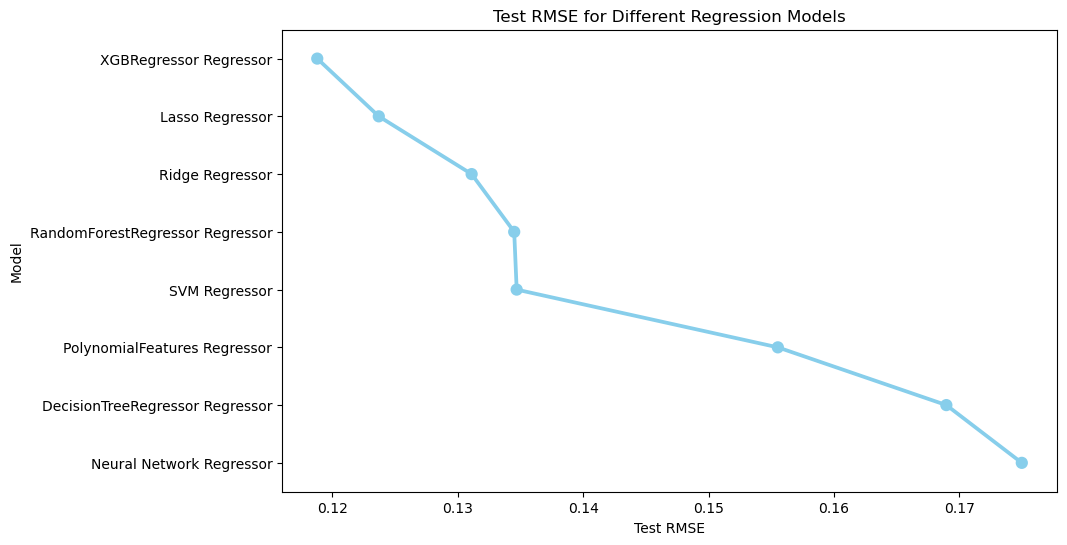

In [48]:
plt.figure(figsize=(10, 6))
sns.pointplot(x='Test RMSE', y='Model', data=rmse_df, color='skyblue', markers='o')
plt.xlabel('Test RMSE')
plt.title('Test RMSE for Different Regression Models')
plt.show()

In [50]:
XG_predictions = XG_reg.predict(test)

In [51]:
sub = pd.DataFrame()
sub['Id']= testFinal['Id']
sub['SalePrice'] = XG_predictions

In [57]:
sub.shape

(1459, 2)

In [53]:
sub.head()

,Id,SalePrice
0,1461,11.744031
1,1462,11.914356
2,1463,12.172716
3,1464,12.132471
4,1465,12.230435


In [56]:
sub.to_csv('./HousePrice_Submission_1.csv', index=False)